In [1]:
import sys
sys.path.append("../")
import numpy as np
import matplotlib.pyplot as plt
from GraphDataset import GraphDataset, MultiGraphDataset
from creditlearning import CreditLearner
import matplotlib


matplotlib.font_manager._rebuild()
plt.rcParams.update({'font.size': 22, 'font.family': 'Arial',
                    'mathtext.fontset': 'custom',
                    'mathtext.rm': 'Arial',
                    'mathtext.cal': 'Arial:italic',
                    'mathtext.it': 'Arial:italic',
                    'mathtext.bf': 'Arial:bold'})

### Demonstration of multiple superimposed processes

Each process has 3 event types. The transition matrix is
\begin{matrix} 
0.05 & 0.75 & 0.2\\ 
0.2 & 0.05 & 0.75\\ 
0.75 & 0.2 & 0.05
\end{matrix}

The transition times between events are chosen to be normal with a lower bound cutoff, which here is chosen to be 0.0001. The means and variances for each transition are drawn from uniform distributions. Here the means are drawn from $\text{Unif} \sim [0,10]$ and variances from $\text{Unif} \sim [0,2]$. 

We simulate a maximum of 7 superimposed processes here. 


In [2]:
np.random.seed(50)
dt = 0.01

def dist(x,i):
    if i%3==0:
        return np.array([0.05,0.75,0.2])
    elif i%3==1:
        return np.array([0.2,0.05,0.75])
    else:
        return np.array([0.75,0.2,0.05])

mean_scale = 10
var_scale = 2
min_cutoff = 0.0001

maxNumProcesses = 7
numNodesList = [3 for i in range(maxNumProcesses)]
pList = [1 for i in range(maxNumProcesses)]
scaleList = [(mean_scale,var_scale) for i in range(maxNumProcesses)]
multigraph1 = MultiGraphDataset(numNodesList=numNodesList,
                                pList=pList,
                                scaleList=scaleList,
                                uniformTime=0,
                                dist=dist,
                                uniformTransitions=False,
                                dt=dt,
                                labelList=None
                               )


Graph showing the connections between events, with edge weights representing mean transition times. 

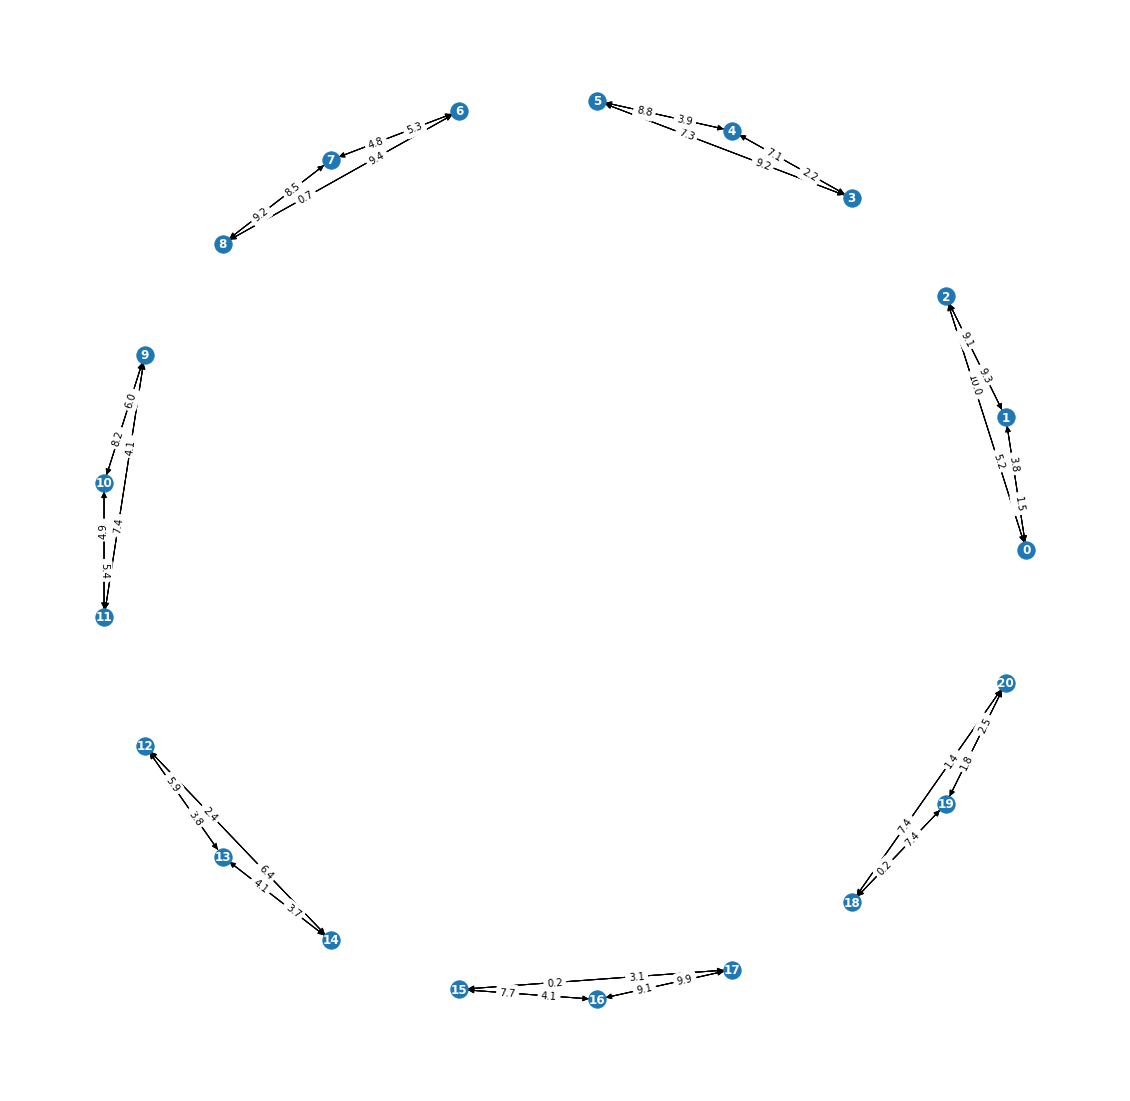

Transition probs and times for first process


{0: {0: {'weight': 3.963299097227769, 'var': 0.8163944006663941, 'prob': 0.05},
  1: {'weight': 3.77315097691124, 'var': 1.543787989679427, 'prob': 0.75},
  2: {'weight': 9.965742301546493, 'var': 1.5210733760177686, 'prob': 0.2}},
 1: {0: {'weight': 1.4546685649615498, 'var': 1.11991420744425, 'prob': 0.2},
  1: {'weight': 9.726646847174504, 'var': 0.6271814929934092, 'prob': 0.05},
  2: {'weight': 9.091784379924901, 'var': 1.7764000750477764, 'prob': 0.75}},
 2: {0: {'weight': 5.24103502664114, 'var': 1.33667513755336, 'prob': 0.75},
  1: {'weight': 9.280009278165524, 'var': 0.10451738221301854, 'prob': 0.2},
  2: {'weight': 5.713730690389266, 'var': 0.6541146081260292, 'prob': 0.05}}}

In [3]:
multigraph1.plotComposedGraph(figsize=(20,20))

print("Transition probs and times for first process")
multigraph1.graphs[0].connections

Given a set of $n$ processes, we generate 6 iterations, training and testing on each one separately. We then compute the average accuracy and uncertainty. Each process has 500 events, so the total number of events for $n$ processes is $500n$. The initial spacing between processes is picked to be 1. We train on $80%$ of the events and test on the remaining. 

The memory of the agent spans from the minimum time separation between events (here chosen to be 0.0001) to 80 with $200$ log-spaced nodes. The fuzziness factor $k=8$. The learning rate for the credit is chosen to make learning quick but ensure convergence. 

To test, the agent is provided the time to the next event and is asked to predict its identity. 

In [4]:
totalRuns = 6
numEventsPerProcess = [500 for i in range(maxNumProcesses)]
offsets = [i for i in range(maxNumProcesses)]
numStimuliPerProcess = [3*(i+1) for i in range(maxNumProcesses)]

allAccuracies = np.zeros((totalRuns,maxNumProcesses))
allAccuraciesM = np.zeros((totalRuns,maxNumProcesses))
allAccuraciesBaseline = np.zeros((totalRuns,maxNumProcesses))

for i in range(totalRuns):
    print(i)
    multigraph1.generateEvents(numEventsPerProcess,offsets=offsets,cutoff=min_cutoff,minTime=True,minSeparation=0.0001)
    trainIndex = int(0.2*len(multigraph1.events))
    minSeparation = np.min(multigraph1.times[1:] - multigraph1.times[:-1])

    trainSet = multigraph1.events[trainIndex:]
    trainTimeInds = multigraph1.timeInds[trainIndex:]
    trainSetOneHot = multigraph1.eventsOneHot[:,trainIndex:]

    testSet = multigraph1.events[:trainIndex]
    testTimeInds = multigraph1.timeInds[:trainIndex]
    testSetOneHot = multigraph1.eventsOneHot[:,:trainIndex]


    for j,n in enumerate(numStimuliPerProcess):
        print(n)

        indices = np.where(trainSet<n)
        trainSubSet = trainSet[indices]
        trainTimeIndsSub = trainTimeInds[indices]
        trainEventsOneHotSub = trainSetOneHot[:n,indices[0]]

        indicesTest = np.where(testSet<n)
        testSubSet = testSet[indicesTest]
        testTimeIndsSub = testTimeInds[indicesTest]
        testEventsOneHotSub = testSetOneHot[:n,indicesTest[0]]

        clgraph = CreditLearner(tau_min=minSeparation/10,tau_max=80,num_taustars=200,
                            delta_min=minSeparation,delta_max=30,k=8,dt=dt,
                            num_stimuli=n,#multigraph1.totalNodes,
                            lrM=1,lrC=10,gradientClip=100,stimuli_labels=multigraph1.labels)
        clgraph.prelearnM(f=trainEventsOneHotSub,
                      event_times=trainTimeIndsSub)
        clgraph.learnCreditFast(f=trainEventsOneHotSub,
                            event_times=trainTimeIndsSub,
                            suppressM=True,adaptlr=True,verbose=500)

        accuracies, accuraciesM, accuraciesBaseline, perplexities, perplexitiesM, perplexitiesBaseline = clgraph.predictOnSequence(f=testEventsOneHotSub,
                                            event_times=testTimeIndsSub,
                                            withMprediction=True, doublecount=True,verbose=0,returnPredictions=False)

        allAccuracies[i,j] = accuracies
        allAccuraciesM[i,j] = accuraciesM
        allAccuraciesBaseline[i,j] = accuraciesBaseline


np.save('allAccuracies',allAccuracies)
np.save('allAccuraciesM',allAccuraciesM)
np.save('allAccuraciesBaseline',allAccuraciesBaseline)

0
3
Reached event:  0 / 238
Using M with double counting
Accuracy C :  0.8793103448275862
Accuracy M :  0.603448275862069
Baseline probability :  0.3275862068965517
6
Reached event:  0 / 433
Using M with double counting
Accuracy C :  0.6238532110091743
Accuracy M :  0.23853211009174313
Baseline probability :  0.1743119266055046
9
Reached event:  0 / 639
Reached event:  500 / 639
Using M with double counting
Accuracy C :  0.46875
Accuracy M :  0.1375
Baseline probability :  0.11875
12
Reached event:  0 / 889
Reached event:  500 / 889
Using M with double counting
Accuracy C :  0.32142857142857145
Accuracy M :  0.14285714285714285
Baseline probability :  0.08482142857142858
15
Reached event:  0 / 1286
Reached event:  500 / 1286
Reached event:  1000 / 1286
Using M with double counting
Accuracy C :  0.23853211009174313
Accuracy M :  0.1529051987767584
Baseline probability :  0.10703363914373089
18
Reached event:  0 / 1563
Reached event:  500 / 1563
Reached event:  1000 / 1563
Reached event:

Reached event:  0 / 1924
Reached event:  500 / 1924
Reached event:  1000 / 1924
Reached event:  1500 / 1924
Using M with double counting
Accuracy C :  0.2
Accuracy M :  0.12291666666666666
Baseline probability :  0.075


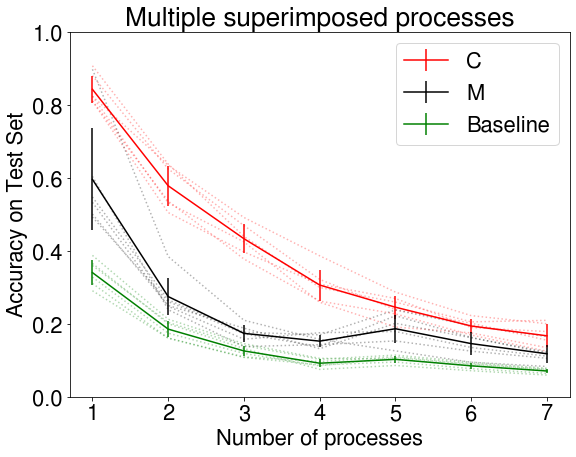

<Figure size 432x288 with 0 Axes>

In [6]:
# allAccuracies = np.load('./final data/allAccuracies.npy')
# allAccuraciesM = np.load('./final data/allAccuraciesM.npy')
# allAccuraciesBaseline = np.load('./final data/allAccuraciesBaseline.npy')
# allPerplexities = np.load('./final data/allPerplexities.npy')
# allPerplexitiesM = np.load('./final data/allPerplexitiesM.npy')
# allPerplexitiesBaseline = np.load('./final data/allPerplexitiesBaseline.npy')

# print(allAccuracies)

maxNumProcesses = allAccuracies.shape[1]
plt.figure(figsize=(1.4*6.4,1.4*4.8))
matplotlib.font_manager._rebuild()
plt.rcParams.update({'font.size': 22, 'font.family': 'FreeSans',
                    'mathtext.fontset': 'custom',
                    'mathtext.rm': 'FreeSans',
                    'mathtext.cal': 'FreeSans:oblique',
                    'mathtext.it': 'FreeSans:oblique',
                    'mathtext.bf': 'FreeSans:bold'})

plt.title("Multiple superimposed processes")
plt.ylim(0,1)
plt.xticks(np.arange(1,maxNumProcesses+1))
plt.xlabel("Number of processes")
plt.ylabel("Accuracy on Test Set")


for i in range(allAccuracies.shape[0]):
    plt.plot(np.arange(1,maxNumProcesses+1),allAccuracies[i],ls='dotted',color='red',alpha=0.3)
    plt.plot(np.arange(1,maxNumProcesses+1),allAccuraciesM[i],ls='dotted',color='black',alpha=0.3)
    plt.plot(np.arange(1,maxNumProcesses+1),allAccuraciesBaseline[i],ls='dotted',color='green',alpha=0.3)


plt.errorbar(np.arange(1,maxNumProcesses+1),np.mean(allAccuracies,axis=0),np.sqrt(np.var(allAccuracies,axis=0)),label="C",color='red')
plt.errorbar(np.arange(1,maxNumProcesses+1),np.mean(allAccuraciesM,axis=0),np.sqrt(np.var(allAccuraciesM,axis=0)),label="M",color='black')
plt.errorbar(np.arange(1,maxNumProcesses+1),np.mean(allAccuraciesBaseline,axis=0),np.sqrt(np.var(allAccuraciesBaseline,axis=0)),label="Baseline",color='green')


plt.legend()
plt.show()
plt.savefig('./accuracyVnumProcesses.png')